In [ ]:
# When running in google colab uncomment following lines.

!git clone https://github.com/Divyansh9125/EE-769-Course-Project---Deep-Image-Prior
!mv EE-769-Course-Project---Deep-Image-Prior/* ./

Cloning into 'EE-769-Course-Project---Deep-Image-Prior'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 45 (delta 8), reused 24 (delta 2), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [ ]:
from __future__ import print_function
%matplotlib inline 

import os
import numpy as np
from models import *

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.optim

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

from skimage.measure import compare_psnr
from denoising_utility import *

In [ ]:
imsize =-1
PLOT = True
sigma = 50
sigma_ = sigma/255.

In [ ]:
img_path = 'data/original.png'

## Loading Image

Original Image: 


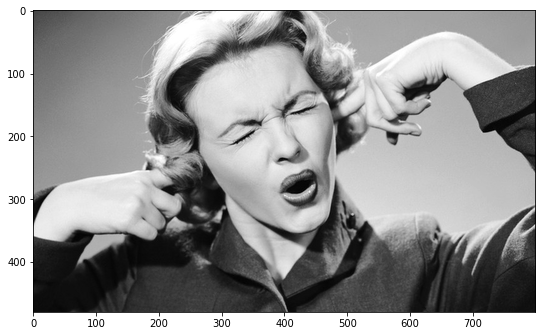


Noised Image: 


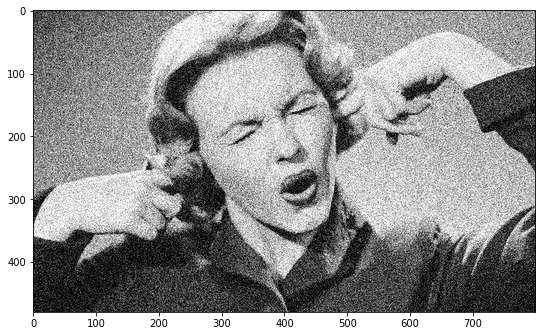

In [ ]:
img_pil = crop_image(get_image(img_path, imsize)[0], d=16)
img_np = pil_to_np(img_pil)
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
if PLOT:
  print('Original Image: ')
  plot_image_grid([img_np], 1, 8);
  print('\nNoised Image: ')
  plot_image_grid([img_noisy_np], 1, 8);

In [ ]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./20. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 2500
input_depth = 1
figsize = 8

# creates a convolutional network with skip connections
net = get_net(input_depth, 'skip', pad, n_channels=1,
              skip_n33d=128, skip_n33u=128, skip_n11=4, 
              num_scales=5, upsample_mode='bilinear').type(dtype)


# get initial noised image (random) from which the network will try and build up output image
# denoted as z in the paper
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 

print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2181737


In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std) #changing the input to the netwok
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight) #calculating average network output
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    # caculating psrn
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Output Image from the network: 


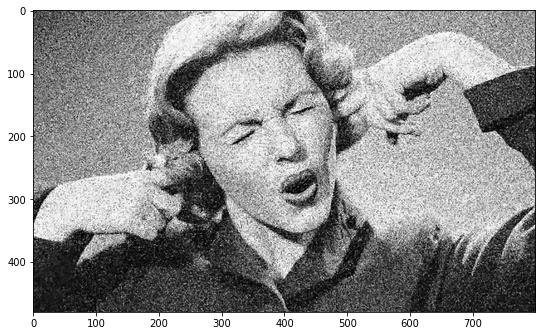


Noised Image: 


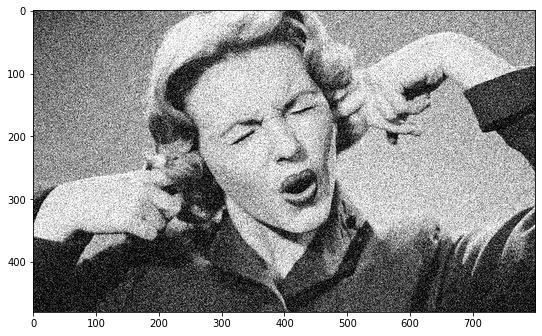


Original Image: 


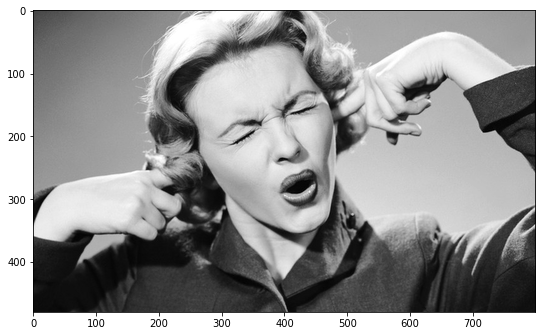

In [ ]:
out_np = torch_to_np(net(net_input))

print('Output Image from the network: ')
plot_image_grid([np.clip(out_np, 0, 1)], factor=8);

print('\nNoised Image: ')
plot_image_grid([img_noisy_np], factor=8);

print('\nOriginal Image: ')
plot_image_grid([img_np], factor=8);